# Malignant Comments Classifier Project

In this article, we will see how to develop a text classification model with multiple outputs. We will be developing a text classification model that analyzes a textual comment and predicts multiple labels associated with the comment. The multi-label classification problem is actually a subset of multiple output model. At the end of this article you will be able to perform multi-label text classification on your data.

At this point, it is important to explain the difference between a multi-class classification problem and a multi-label classification. In multi-class classification problem, an instance or a record can belong to one and only one of the multiple output classes. For instance, in the sentiment analysis problem that we studied in the last article, a text review could be either "good", "bad", or "average". It could not be both "good" and "average" at the same time. On the other hand in multi-label classification problems, an instance can have multiple outputs at the same time. For instance, in the text classification problem that we are going to solve in this article, a comment can have multiple tags. These tags include "toxic", "obscene", "insulting", etc., at the same time.

In [17]:
import re
import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
db = pd.read_csv("train.csv")
db.head()

id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [21]:
comments_labels = db[["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]]
comments_labels.head()

malignant  highly_malignant  rude  threat  abuse  loathe
0          0                 0     0       0      0       0
1          0                 0     0       0      0       0
2          0                 0     0       0      0       0
3          0                 0     0       0      0       0
4          0                 0     0       0      0       0

In [5]:
df_cat = db.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_cat.columns.values)
for i in categories:
    counts.append((i, df_cat[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

category  number_of_comments
0         malignant               15294
1  highly_malignant                1595
2              rude                8449
3            threat                 478
4             abuse                7877
5            loathe                1405

Text(0.5, 0, 'category')

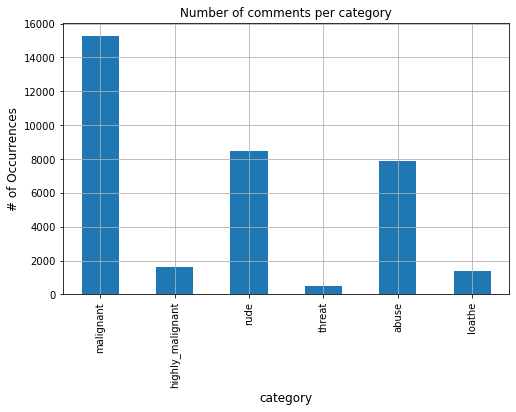

In [6]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Multi-Label

Text(0.5, 0, '# of categories')

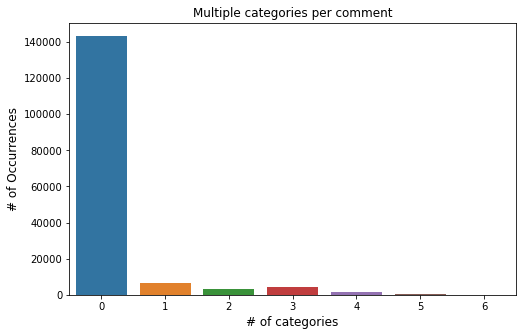

In [7]:
rowsums = db.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

majority of the comment text are not labeled

In [8]:
print('Percentage of comments that are not labelled:')
print(len(db[(db['malignant']==0) & (db['highly_malignant']==0) & (db['rude']==0) & (db['threat']== 0) & (db['abuse']==0) & (db['loathe']==0)]) / len(db))

Percentage of comments that are not labelled:
0.8983211235124177


### The distribution of the number of words in comment texts

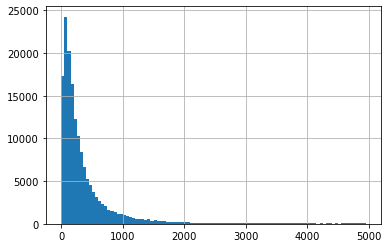

In [10]:
lens = db.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [11]:
print('Number of missing comments in comment text:')
db['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

## Data Preprocessing

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [15]:
db['comment_text'] = db['comment_text'].map(lambda com : clean_text(com))
db['comment_text'][1]

'd aww he matches this background colour am seemingly stuck with thanks talk january utc'

In [41]:
categories = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
train, test = train_test_split(db, random_state=42, test_size=0.20, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(127656,)
(31915,)


## Classifiers Training

**Pipeline**
*Scikit-learn provides a pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier*

### OneVsRest multi-label strategy
***The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.***

### 1. Naive Bayes

In [23]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing malignant
Test accuracy is 0.9235469215102616
... Processing highly_malignant
Test accuracy is 0.989942033526555
... Processing rude
Test accuracy is 0.9531568228105907
... Processing threat
Test accuracy is 0.9976813410621964
... Processing abuse
Test accuracy is 0.9521854927150243
... Processing loathe
Test accuracy is 0.9907880307065643


## 2. LinearSVC

In [42]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing malignant
Test accuracy is 0.9606454645151182
... Processing highly_malignant
Test accuracy is 0.990474698417672
... Processing rude
Test accuracy is 0.9794767350775497
... Processing threat
Test accuracy is 0.9976813410621964
... Processing abuse
Test accuracy is 0.9712047626507911
... Processing loathe
Test accuracy is 0.9920726930910231


# 3. Logistic Regression

In [43]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing malignant
Test accuracy is 0.9558201472661758
... Processing highly_malignant
Test accuracy is 0.9908506971643428
... Processing rude
Test accuracy is 0.976468745104183
... Processing threat
Test accuracy is 0.9977440075199749
... Processing abuse
Test accuracy is 0.969732100892997
... Processing loathe
Test accuracy is 0.9916966943443521


#### As we can see that out of all 3 classifier models the heighest accuracy has 'LinearSVC'model.

## Predict test data

In [38]:
test1 = pd.read_csv("test.csv")
test1.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [39]:
test1['comment_text'] = test1['comment_text'].map(lambda com : clean_text(com))

In [46]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(test1['comment_text'])
    test1[category] = prediction
    print('... completed {}'.format(category))
print('done...')

... Processing malignant
... completed malignant
... Processing highly_malignant
... completed highly_malignant
... Processing rude
... completed rude
... Processing threat
... completed threat
... Processing abuse
... completed abuse
... Processing loathe
... completed loathe
done...


In [47]:
test1.head()

id                                       comment_text  \
0  00001cee341fdb12  yo bitch ja rule is more succesful then you wi...   
1  0000247867823ef7           from rfc the title is fine as it is imo    
2  00013b17ad220c46                    sources zawe ashton on lapland    
3  00017563c3f7919a   if you have look back at the source the infor...   
4  00017695ad8997eb         i do not anonymously edit articles at all    

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          1                 0     1       0      1       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [49]:
test1.to_csv('predict_data.csv',index=False)